<a href="https://colab.research.google.com/github/leeds1219/DL_and_AI_Notes_and_Projects/blob/main/Generative_Adversarial_Networks_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 20. Generative Adversarial Networks

In [ ]:
# 20.1 GAN uses a two-sample test

# Generator with Noise(z) input creates a Fake G(z)
# Discriminator with input(x)
# classify if it is real or fake
# when the fake G(z) pass the classifier an image(speech etc) is generated

# The discriminator is a binary classifier to distinguish if the input(x) is real
# or fake (from generator) and gives an scalr prediction o(a real number) for input using
# a fully connected layer with hidden size 1 and then applies sigmoid function
# to obtain the predicted probability D(x) = 1/(1+exp(-o)).
# Assume the label y for the true data is 1 and fake is 0.

# We train the discriminator to minimize the cross-entropy loss
# min(D){-ylogD(x)-(1-y)log(1-D(x))}

# For the Generator it draws some parameter z from z ~ N(0,1) z is called latent variable
# it applies a function to generate x` = G(z).
# The goal of the gnerator is to fool the discriminator to classify x` = G(z) as true
# Thus we want D(G(z)) ~ 1 for given discriminator D we update the parameters of G to
# maximize cross-entropy loss when y = 0(fake)
# max(G){-(1-y)log(1-D(G(z)))} = max(G){-log(1-D(G(z)))}

# If D(x`) ~ 1 so loss is near 0.
# So we minimize the following loss
# min(G){-ylog(D(G(z)))} = min(G){-log(D(G(z)))}

# which is just feeding x` = G(z) into the discriminator but giving label y = 0(true)
# In other words, D and G are playing a "minimax" game!!!
# min(D)max(G){-E_x~DatalogD(x)-E_z~Noiselog(1-D(G(z)))}

#  We will illustrate what happens if we use GANs to build
# the world’s most inefficient estimator of parameters for a Gaussian

In [1]:
# d2l in colab
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:


In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
# 20.1.1. Generate Some "Real" Data

X = torch.normal(0.0, 1, (1000,2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

# This should be a Gaussian shifted in some arbitary way with mean b
# and covariance matrix A^TA.

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


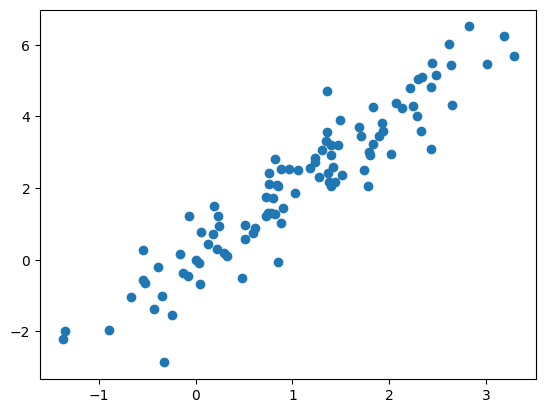

In [4]:
d2l.set_figsize
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100,(1)].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [5]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [6]:
# 20.1.2. Generator

# A sequential network with a single linear layer
# nn.Sequential creates an container
# nn.Linear(2,2) defines a linear layer Linear(# of input features, # of output features)
# which is a fully connected layer
# this is a simple feedforward nn
net_G = nn.Sequential(nn.Linear(2,2))

In [7]:
# 20.1.3. Discriminator

# MLP with 3 layers and 2 Tanh activation function to introduce non-linearity
# third layer flattens the output to 1 dimension, for binary classification tasks
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1)
)

In [8]:
# 20.1.4. Training

# Discriminator update
def update_D(X, Z, net_D, net_G, loss, trainer_D) :
# Check input tensor X shape specifically retrieves
# the size (length) of the first dimension of the array or tensor.
# The first dimension is often associated with the number of samples or elements in a dataset,
# and it's typically used when dealing with batch processing in deep learning.
  batch_size = X.shape[0]
# .device attribute is used to determine or set the device (usually a CPU or a GPU)
# on which a PyTorch tensor or model resides.
# It allows you to manage the placement of your data and models for computations.
# ones and zeros are labels for real and fake data
  ones = torch.ones((batch_size,), device = X.device)
  zeros = torch.zeros((batch_size,), device = X.device)
# It clears the gradients of discriminator's parameters to prepare for backpropagation
  trainer_D.zero_grad()
# computes the discriminator's output for real X
  real_Y = net_D(X)
# generates fake data using net_G with noise Z
  fake_X = net_G(Z)
# Do not need to compute gradient for `net_G`, detach it from computing
# .detach() is used to prevent gradients from being propagated back to the generator
# during the computation of fake_Y.
# This is a common practice in GAN training where you only want to update the discriminator's parameters
# and not the generator's parameters during the discriminator update.
# this computes the discriminator's output for the generated fake data(above)
  fake_Y = net_D(fake_X.detach())
# Discriminator loss one for real one for fake
# binary cross-entropy loss
# the loss is assumed to be a binary cross-entropy loss function
  loss_D = (loss(real_Y, ones.reshape(real_Y.shape)))+loss(fake_Y, zeros.reshape(fake_Y.shape))/2
# computes the gradients of discriminator's parameters with respect to the loss
  loss_D.backward()
# updates discriminator's parameters
# trainer_D is an instance of torch.optim.Optimizer
  trainer_D.step()
  return loss_D
# discriminator is updated based on the real and fake data to better distinguish between them.

In [9]:
# The Generator update

# similarly updated reusing the cross-entropy loss but changing the label of fake
# data from 0 to 1
def update_G(Z, net_D, net_G, loss, trainer_G) :
  batch_size = Z.shape[0]
  ones = torch.ones((batch_size,), device = Z.device)
  trainer_G.zero_grad()

  fake_X = net_G(Z)

  fake_Y = net_D(fake_X)
  loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
  loss_G.backward()
  trainer_G.step()
  return loss_G

In [10]:
# Both D and G performs a binary logistic regression with ce-loss
# We use Adam to smooth the training process
# in each iteration we fist update D and G
# visualize both losses and generated examples.

def train(net_d, netG, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):

  loss = nn.BCEWithLogitsLoss(reduction = 'sum')

  for w in net_D.parameters():
    nn.init.normal_(w,0,0.02)
  for w in net_G.parameters():
    nn.init.normal_(w,0,0.02)

  trainer_D = torch.optim.Adam(net_D.parameters(), lr = lr_D)
  trainer_G = torch.optim.Adam(net_G.parameters(), lr = lr_G)

  animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss', xlim = [1, num_epochs], nrows = 2,
                          figsize = (5, 5), legend = ['discriminator', 'generator'])
  animator.fig.subplots_adjust(hspace = 0.3)

  for epoch in range(num_epochs) :

    timer = d2l.Timer()

    metric = d2l.Accumulator(3)

    for (X, ) in data_iter:
      batch_size = X.shape[0]
      Z = torch.normal(0,1,size = (batch_size, latent_dim))
      metric.add(update_D(X,Z,net_D,net_G,loss,trainer_D),
                 update_G(Z,net_D,net_G,loss,trainer_G),
                 batch_size)

      Z = torch.normal(0,1,size=(100,latent_dim))
      fake_X = net_G(Z).detach().numpy()
      animator.axes[1].cla()
      animator.axes[1].scatter(data[:, 0], data[:, 1])
      animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
      animator.axes[1].legend(['real', 'generated'])

      loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
      animator.add(epoch + 1, (loss_D, loss_G))

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

KeyboardInterrupt: ignored

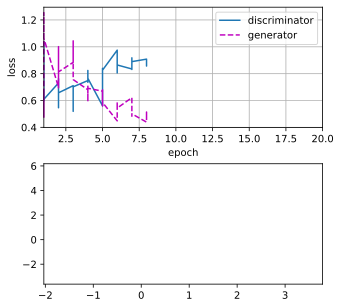

In [15]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D,net_G,data_iter,num_epochs,lr_D,lr_G,latent_dim,data[:100].detach().numpy())

In [ ]:
# trained with cpu and laptop almost blewup... pls use GPU...

In [11]:
torch.cuda.is_available()

True

In [ ]:
# result is some what quite different from the originer textbook...
# why???

# 20.2. Deep Convolutional Generative Adversarial Networks

In [12]:
# 20.2. DCGAN

import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [13]:
# 20.2.1. The Pokemon Dataset

d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [14]:
# resize each image into 64 64 tensor by ToTensor transformation
# projecting the pixel value into [0,1]
# while our Gernerator will use ths tanH to obtain outputs in [-1,1]
batch_size = 256
transformer = torchvision.transforms.Compose([
# resize each image into 64 64 tensor by ToTensor transformation
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
# normalize the data with 0.5 mean and 0.5 std
    torchvision.transforms.Normalize(0.5,0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size = batch_size,
    shuffle=True, num_workers = d2l.get_dataloader_workers()
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


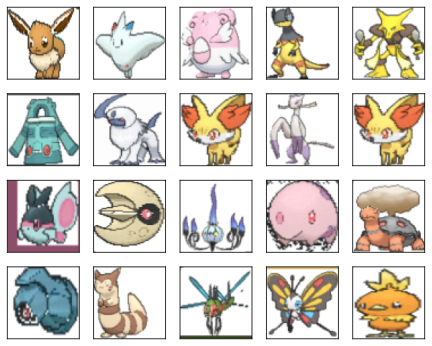

In [15]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

In [16]:
# 20.2.2. The Generator

# The generator needs to map the nois variable z in R^d with length d vector, to a
# RGB image with width and height to be 64 64

class G_block(nn.Module):
  def __init__(self, out_channels, in_channels = 3, kernel_size = 4, strides = 2,
               padding = 1, **kwargs):
    super(G_block,self).__init__(**kwargs)
    self.conv2d_trans = nn.ConvTranspose2d(in_channels,out_channels,
                                           kernel_size, strides, padding, bias=False)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()
  def forward(self, X):
    return self.activation(self.batch_norm(self.conv2d_trans(X)))

# in default transposed conv layer uses a k_h = k_w = 4 kernel, a s_h = s_w = 2 strides,
# and a p_h=p_w=1 padding
# with input [16 16] generator block will double input to [32 32]

In [18]:
x =torch.zeros((2,3,16,16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

In [23]:
# if changing the conv layer to 4 4 and 1 1 stride and zeropadding
# input 1 1 will be increased by 3 3 result 4 4
#
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

In [24]:
n_G = 64 # hyperparameter that determines the width of the network

net_G = nn.Sequential(
# if changing the conv layer to 4 4 and 1 1 stride and zeropadding
# input 1 1 will be increased by 3 3 result 4 4
    G_block(in_channels = 100, out_channels = n_G*8, # input 100 1 1
            strides = 1, padding = 0),              # 64*8 4 4(1(h_in)-4(kernel))/1(stride)+1(bias)=4(?)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # 64*4 8 8 # didnt understand this part...
    G_block(in_channels=n_G*4, out_channels=n_G*2), # 64*2 16 16
    G_block(in_channels=n_G*2, out_channels=n_G),   # 64*1 32 32
    nn.ConvTranspose2d(in_channels = n_G, out_channels = 3,
                       kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
)
# final output is batch_size 3(the RGBs) 64 64

# The generator consists of four basic blocks that increase input’s both
# width and height from 1 to 32. At the same time,
# it first projects the latent variable into 64*8 channels
# and then halve the channels each time.
# At last, a transposed convolution layer is used to generate the output.
# It further doubles the width and height to match the desired 64*^4 shape
# and reduces channel size to 3
# The tanh activation function is applied to project output values into the (-1 1) range

In [21]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

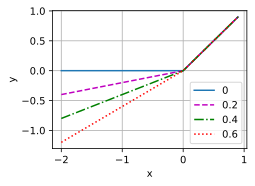

In [25]:
# 20.2.3. Discriminator
# uses leakyReLU It aims to fix the “dying ReLU” problem

# depending on alpha values
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

In [26]:
# basic block of D
# batch norm and leaky ReLU
# similar to G_block

class D_block(nn.Module):
  def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
    super(D_block, self).__init__(**kwargs)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.LeakyReLU(alpha, inplace=True)

  def forward(self, X):
    return self.activation(self.batch_norm(self.conv2d(X)))
# default setting n 16 16 k 4 4 s 2 2 p 1 1 output 8 8

In [27]:
# D is the mirror of G

x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

In [28]:
n_D = 64

net_D = nn.Sequential(
  D_block(n_D),  # Output: (64, 32, 32)
  D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
  D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
  D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
  nn.Conv2d(in_channels=n_D*8, out_channels=1,
            kernel_size=4, bias=False))  # Output: (1, 1, 1) for prediction value!

In [29]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

In [32]:
# 20.2.4. Training

# we use the same lr for G and D
# change beta 1 in Adam from 0.9 to 0.5 decreases the smoothness
# exp weighted moving average of past gradients to take care of the rapid changing
# gradients because the G and D fight eachother

def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

In [33]:
torch.cuda.is_available()

True

loss_D 0.024, loss_G 7.425, 842.7 examples/sec on cuda:0


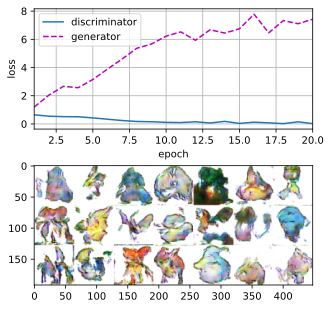

In [34]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

In [ ]:
# DCGAN architecture has four convolutional layers for the Discriminator
# and four “fractionally-strided” convolutional layers for the Generator.

# The Discriminator is a 4-layer strided convolutions with batch normalization
# (except its input layer) and leaky ReLU activations.

# Leaky ReLU is a nonlinear function that give a non-zero output for a negative input.
# It aims to fix the “dying ReLU” problem
# and helps the gradients flow easier through the architecture.

In [ ]:
# Minimax << review AI lecture... missed out a lot on this part didnt understand the concept perfectly..

In [ ]:
# What will happen if we use standard ReLU activation rather than leaky ReLU?
# Apply DCGAN on Fashion-MNIST and see which category works well and which does not.